<span style="font-size:200%">Inferencia Bayesiana</span><br>
<span style="color: gray">dic 2019</span><br>
[*Alberto Ruiz*](http://dis.um.es/profesores/alberto)

Con frecuencia debemos estimar magnitudes desconocidas a partir de información incompleta y ruidosa. La inferencia Bayesiana permite aplicar el razonamiento lógico en situaciones con incertidumbre.

### Motivación

In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

from matplotlib import rc
#rc('text', usetex=True)
#rc('font', size=14)

G = np.random.randn

def show1ddata(x, sz=(8,0.5), **kwargs):
    plt.figure(figsize=sz)
    
    options = { 'marker': 'x', 's': 60, 'alpha': 0.75, 'color':'blue' }
    options.update(kwargs)
    
    plt.ylim(-1,1);
    plt.scatter(x,x*0, zorder=5, **options);
    
    ax = plt.gca()
    ax.spines['left'].set_visible(False)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.set_yticklabels([])
    ax.set_yticks([])
    ax.spines['bottom'].set_position('zero')
    ax.spines['bottom'].set_color('gray')
    
    col = 'gray'
    ax.tick_params(axis='x', colors=col)
    
def shbracket(x, k=2):
    m = x.mean()
    s = x.std()
    d = 0.6
    plt.fill_between([m-k*s,m+k*s], [d,d], -d, alpha=0.2, color='green')

Supongamos que queremos estimar los parámetros ($\mu$, $\sigma$) de una gaussiana 1D a partir de unas pocas muestras:

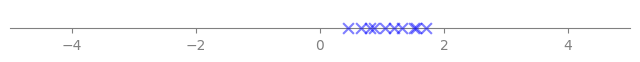

In [2]:
n = 10

μ = 1
σ = 0.5

data = μ  +  σ * G(n)
#print(data)
show1ddata(data, color='blue', alpha=0.5)
plt.xlim(-5,5);

Lo usual es calcular la media y la desviación estándar. Cuanto mayor sea $n$ más se aproximarán a los valores reales.

In [3]:
print(f'mean={np.mean(data):.3f}, std={np.std(data):.3f}')

mean=1.112, std=0.394


Con esos estadísticos podemos establecer una región que englobe a la mayoría de las muestras recogidas (y esperamos que también futuras, si $n$ no es muy pequeño).

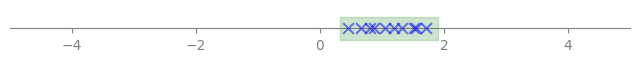

In [4]:
show1ddata(data, color='blue', alpha=0.5)
plt.xlim(-5,5);
shbracket(data)

Pero a veces los datos disponibles están contaminados con  "outliers", y lo que es peor, es posible que la proporción  $\varepsilon$ de dichos outliers sea desconocida.

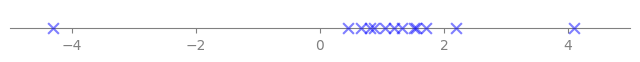

In [5]:
noisydata = np.append(data,[-4.3, 2.2, 4.1])

show1ddata(noisydata, color='blue', alpha=0.5)
plt.xlim(-5,5);

En estas condiciones la media y la dispersión pueden quedar muy distorsionadas y dejan de tener utilidad.

In [6]:
print(f'mean={np.mean(noisydata):.3f}, std={np.std(noisydata):.3f}')

mean=1.009, std=1.772


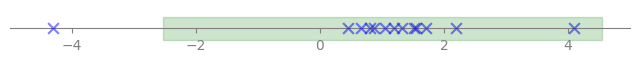

In [7]:
show1ddata(noisydata, color='blue', alpha=0.5)
plt.xlim(-5,5);
shbracket(noisydata)

Podríamos quitar "a ojo" las muestras que tengan pinta de ser "malas", pero esto es poco riguroso y arriesgado. Lo ideal sería obtener buenas estimaciones de $\mu$ y $\sigma$ resistentes a los outliers y además, nos gustaría cuantificar su precisión.

Consideremos ahora el problema de la regresión lineal. Tenemos un conjunto de medidas $(x_k,y_k)$ como las que se muestran en la figura siguiente, y sospechamos que obedecen una sencilla ley de tipo $y = a+bx$. La variable $x$ puede considerarse exacta (nosotros la controlamos), pero la variable $y$ presenta un cierto ruido de medida, que suponemos gaussiano pero de intensidad $\sigma$ desconocida.

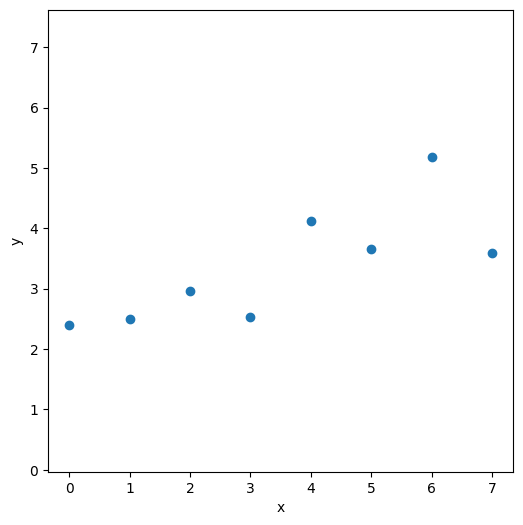

In [8]:
plt.figure(figsize=(6,6))

α = 1/3
β = 2
σ = 0.5

X = np.arange(8)
n = len(X)
Y = α*X + β + σ*G(n)

plt.plot(X,Y,'o'); plt.axis('equal'); plt.xlabel('x'); plt.ylabel('y');

El modelo lineal obtenido por mínimos cuadrados (recta de regresión) es:

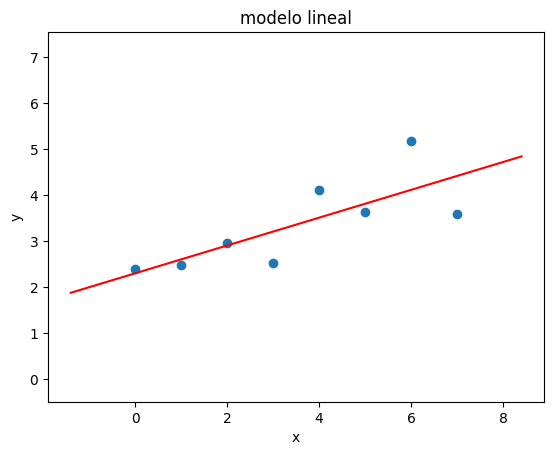

In [9]:
A = np.vander(X,2)
B = Y
sol = np.linalg.lstsq(A,B,rcond=None)[0]

#print(sol)
mn,mx = X.min(), X.max()
d = (mx-mn)/5
xc = np.linspace(mn-d,mx+d,100)
ye = np.vander(xc,2) @ sol


plt.plot(X,Y,'o'); plt.axis('equal'); plt.xlabel('x'); plt.ylabel('y');
plt.plot(xc,ye,'r'); plt.title('modelo lineal');

Si el número de datos disponible es pequeño el modelo obtenido será muy sensible a las posiciones observadas y, por tanto, poco fiable.

Además, podemos plantearnos la posibilidad de que la relación entre las variables en realidad sea no lineal, por ejemplo del tipo $y = a + bx + cx^2 $.

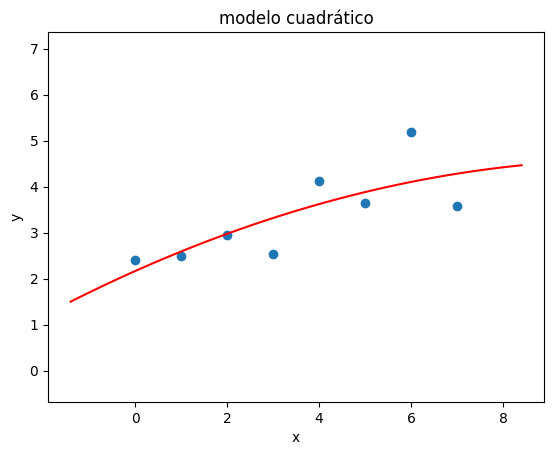

In [10]:
A = np.vander(X,3)
B = Y
sol = np.linalg.lstsq(A,B,rcond=None)[0]

#print(sol)
mn,mx = X.min(), X.max()
d = (mx-mn)/5
xc = np.linspace(mn-d,mx+d,100)
ye = np.vander(xc,3) @ sol


plt.plot(X,Y,'o'); plt.axis('equal'); plt.xlabel('x'); plt.ylabel('y');
plt.plot(xc,ye,'r'); plt.title('modelo cuadrático');

El ruido de medida hace difícil distinguir las dos situaciones.

### Regla de Bayes

Este tipo de problemas debe abordarse con algún método de razonamiento capaz de manejar correctamente la incertidumbre. La [inferencia Bayesiana](https://en.wikipedia.org/wiki/Bayesian_inference) representa la información sobre las magnitudes desconocidas mediante distribuciones de probabilidad y aplica las reglas del cálculo de probabilidades para reducir adecuadamente su incertidumbre en base a la información aportada por los datos experimentales.

$P(\theta)$ es la incertidumbre inicial sobre la magnitud desconocida $\theta$.

$P(d \mid \theta)$ es el modelo de la observación. Para un valor concreto de $\theta$, nos dice lo probable que es cada posible dato d.

$P( d_o \mid \theta)$ es la "verosimilitud" de cualquier posible $\theta$ para un dato concreto observado $d_o$. Es la misma expresión matemática anterior del modelo de observación, pero donde se fija el primer argumento a $d_o$, quedando una función únicamente de $\theta$. 

La regla de Bayes resuelve el problema:

$$P(A , B) = P(A \mid B)\, P(B) = P(B\mid A)\, P(A)$$

$$\underbrace{P(\,\theta \mid d_o\,)}_{posterior} = \underbrace{P(\,d_o \mid  \theta\,)}_{likelihood} \;\underbrace{P(\,\theta\,)}_{prior}\; \underbrace{\frac{1}{P(\,d_o\,)}}_{normalization}$$

Olvidándonos por el momento de la normalización (que en casos sencillos se consigue dividiendo por la suma de todas las posibilidades) la distribución posterior es proporcional al producto del modelo y la distribución inicial.

$$P(\theta \mid  d_o) \propto P(d_o\mid \theta) \; P(\theta)$$

Estos dos ingredientes son en principio sencillos de expresar, matemática o computacionalmente, teniendo en cuenta las características de cada problema concreto. Lo interesante de la expresión anterior es que obtiene automáticamente el "modelo inverso" de cualquier sistema partiendo simplemente del "modelo directo".

### Múltiples datos

Cuando tenemos un conjunto $D$ de datos observados $d_k$ independientes, su verosimilitud es un producto

$$P(D \mid \theta) = \prod_k P(d_k \mid \theta)$$

pero computacionalmente es mejor tomar logaritmos, de modo que la distribución posterior queda:

$$\log P(\theta \mid D) = \sum_k \log P(d_k \mid \theta) + \log p(\theta) \color{gray}{+ K} $$

El proceso de inferencia consiste "simplemente" en evaluar la expresión anterior en los datos $d_k$ observados, para todos los posibles valores de todos los parámetros (normalmente $\theta$ tendrá varias componentes).

### Ejemplos

En el ejemplo de una población normal contaminada con outliers, un posible modelo de medida es una mezcla de una normal y una variable $R$ con mucha dispersión que genera los outliers con probabilidad $\epsilon$. Los parámetros son $\theta = (\mu,\sigma,\epsilon)$.

$$P(x\mid \mu,\sigma,\epsilon) = \epsilon R(x) + (1-\epsilon)\mathcal N[\mu, \sigma](x)$$

Nuestro objetivo es encontrar $P(\mu \sigma \epsilon \mid D)$, y a partir de ahí cualquier marginal como $P(\mu \sigma \mid D)$, o $P(\sigma  \mid D)$, etc.

En el ejemplo de regresión, para una función lineal el modelo de medida puede ser el siguiente, con $\theta=(a,b,\sigma)$.

$$ P(y \mid x,a,b,\sigma) = \mathcal N[a+bx ,\sigma](y) $$

Y para la función cuadrática $\theta=(a,b,c,\sigma)$, con

$$ P(y \mid x,a,b,c,\sigma) = \mathcal N[a+bx+cx^2 ,\sigma](y)  $$

### Resultado

El resultado de la inferencia Bayesiana es la distribución posterior conjunta de todos los parámetros, que puede utilizarse para responder a diferentes preguntas.

Por ejemplo, en el problema de regresión se pueden plantear varios objetivos:

- Por un lado, obtener información $P(ab\mid D)$ sobre los parámetros del modelo lineal o $P(abc\mid D)$ del cuadrático, y sobre la intensidad del ruido $P(\sigma\mid D)$.


- Normalmente estaremos interesados en el resultado de una observación futura $x_n$, cuya incertidumbre expresamos como $P(y\mid x_n)$ y que se calculará marginalizando los demás parámetros (distribución predictiva). Utilizar los más probables es una simplificación en la que perdemos información. Siempre que sea computacionalmente tratable es preferible un ataque Bayesiano completo.


- Finalmente, nos gustaría determinar si realmente merece la pena complicarnos la vida con el modelo cuadrático. La selección Bayesiana de modelos es un método riguroso de control de capacidad, que es una condición necesaria para la generalización.

### Hiperparámetros

Puede ocurrir que tengamos un buen modelo de medida $p(D\mid\theta)$ pero que la información a priori sobre los parámetros sea también imprecisa (p.ej. se desconce su rango de valores posibles). Entonces se puede introducir información a priori sobre ellos, ampliando el modelo:

$$p(d\mid \theta \alpha) = p(d\mid\theta)$$

$$p(\theta\alpha) = p(\theta\mid\alpha)\; p(\alpha)$$

Entonces

$$p(d \mid \theta \alpha) \propto  p(d \mid \theta\alpha)\;p(\theta\alpha) = p(d\mid\theta)\; p(\theta \mid \alpha)\; p(\alpha) $$

Al final se marginalizan los parámetros que no interesan:

$$p(d\mid\theta) =  \sum_\alpha\; p(d\mid\theta\alpha)$$

Siempre es necesario incluir explícitamente la información a priori sobre los parámetros o hiperparámetros para conseguir la distribución a posteriori. Es la característica fundamental de la inferencia Bayesiana. Y se considera algo muy positivo, frente a alternativas donde esta información está implícita en otras suposiciones, o que renuncian completamente a responder con una distribución de probabilidad sobre los parámetros de interés. 

### Parámetros auxiliares

Los parámetros auxiliares ("*nuisance*") también se marginalizan. Esta es una ventaja importante del enfoque Bayesiano. Se introducen parámetros que facilitan la definición del modelo del sensor, y luego desaparecen teniendo en cuenta todas sus posibilidades adecuadamente ponderadas.

### Técnicas

Si las distribuciones son matemáticamente simples (p. ej. Gaussianas) la regla de Bayes se puede aplicar de forma analítica. Esto ocurre por ejemplo en el [Filtro de Kalman](Kalman.ipynb).

Si no es así, pero el número de parámetros es pequeño se puede discretizar el dominio y evaluar explícitamente todas las posibilidades (técnicas de *grid*). Otra posibilidad es representar las distribuciones mediantes muestras (filtro de partículas).

Si el número de parámetros mayor hay que recurrir a las técnicas [MCMC](MCMC.ipynb).